# QF 627 Programming and Computational Finance
### Lesson 10 | Natural Language Processing (NLP) and Trading Strategies

> "Hi Team! 👋

> In our final class, we will learn how to capitalize on `natural language processing` (`NLP`) and `machine learning` to create `trading strategies`. As you will see, this will be informative, helpful knowledge and expertise for creating your trading strategy down the line. 

> First, we will define our real-world questions so that we have them in hand, and then we will prepare stock and news data. Next, we will learn how to go over sentiment analysis, along with supervised and unsupervised learning. Finally, we will go through an assessment of our model and trading strategy on individual stocks and multiple stocks over varying time periods.

### Learning Pointers 

### [Data Import and Transformation](#wrangle)
<br>

### [Natural Language Processing, Sentiment Analysis, and Machine Learning](#nlp)
<br>

### [Predictive Model Assessment, Strategy Building, and Backtesting](#test)

### Activation of necessary modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

#### Setting plotting and display options

In [2]:
np.set_printoptions(precision = 3)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

In [3]:
%matplotlib inline

    PROBLEM STATEMENT
    
> `The real-world question` in our hand is to create a trading strategy that capitalizes on natural language processing to extract information from news headlines, assign a sentiment to that information, and use the sentiment and the information inside the news headlines to create a trading strategy.

We will employ data from three different sources:

* `Yahoo Finance` website for the stock return: The return data can be obtained from another website that is similar to Yahoo finance.
<br>

* `News headlines` data compiled from the RSS feeds of several news websites: This news headlines data is compiled by various news websites and contains the most financially relevant news filtered by human editors. For this study, we will only look at the headline, not the details in the text of the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from May 2011 through December 2018.
<br>

* `Kaggle`: Labeled data of news sentiments obtained for a classification-based sentiment analysis model. This data may not be authentic and is used only for demonstration purposes in our real-world problem solving.
<br>

* A `stock market lexicon` created based on stock market conversations in microblogging services.

### Load additional nececessary packages for our work

In [4]:
# !pip install spacy
# !pip install nltk
# !pip install textblob

# !pip install backtrader

#### NLP libraries

In [5]:
from textblob import TextBlob

import spacy

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

import warnings

import csv

# https://spacy.io/usage/models

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

In [7]:
import en_core_web_sm
nlp = en_core_web_sm.load()

#### Libraries for processing news headlines

In [8]:
from lxml import etree

import json

from io import StringIO
from os import listdir
from os.path import isfile, join
from copy import copy

from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize

#### Libraries for Classification for modeling the sentiments

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### [NOTE: How to Install TensorFlow GPU for Mac M1/M2 with Conda--A Tutorial YouTube Video](https://www.youtube.com/watch?v=5DgWvU0p2bk)

#### Keras package for the deep learning model for the sentiment prediction. 

In [10]:
# !pip install keras
# !pip install tensorflow[and-cuda]
# !pip install tensorflow


In [11]:
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers import Embedding

#### Some additional libraries

In [12]:
import statsmodels.api as sm
import seaborn as sns
import datetime
from datetime import date

import json  
import zipfile
import os.path
import sys

In [13]:
# Diable the warnings
import warnings
warnings.filterwarnings("ignore")

<a id="wrangle"></a>

### Data Import and Transformation

#### Stock Data

In [14]:
tickers = ["AAPL",
           "MSFT",
           "AMZN",
           "GOOG",
           "META",
           "WMT",
           "JPM",
           "TSLA",
           "NFLX",
           "ADBE"]

start = "2010-01-01"
end = "2018-12-31"

In [15]:
DF_stock_return = pd.DataFrame()

for ticker in tickers:
    ticker_YF = yf.Ticker(ticker)
    
    if DF_stock_return.empty:
        DF_stock_return = ticker_YF.history(start = start,
                                            end = end)
        DF_stock_return["ticker"] = ticker

    else:
        temporary_data = ticker_YF.history(start = start,
                                           end = end)
        temporary_data["ticker"] = ticker
        DF_stock_return = pd.concat([DF_stock_return, 
                                     temporary_data]
                                   )

DF_stock_return

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-01-04 00:00:00-05:00,6.453,6.486,6.421,6.471,493729600,0.000,0.000,AAPL
2010-01-05 00:00:00-05:00,6.489,6.519,6.448,6.482,601904800,0.000,0.000,AAPL
2010-01-06 00:00:00-05:00,6.482,6.508,6.372,6.379,552160000,0.000,0.000,AAPL
2010-01-07 00:00:00-05:00,6.402,6.410,6.321,6.367,477131200,0.000,0.000,AAPL
2010-01-08 00:00:00-05:00,6.359,6.410,6.321,6.409,447610800,0.000,0.000,AAPL
...,...,...,...,...,...,...,...,...
2018-12-21 00:00:00-05:00,219.550,222.260,207.370,208.800,8828100,0.000,0.000,ADBE
2018-12-24 00:00:00-05:00,206.900,212.580,204.950,205.160,2940500,0.000,0.000,ADBE
2018-12-26 00:00:00-05:00,206.530,222.960,206.250,222.950,5897900,0.000,0.000,ADBE


In [16]:
DF_stock_return.to_csv("stocks.csv")

> The next step of data preparation is comprised of the following two overarching steps:

* Loading and pre-processing the news data

* Preparing the combined data


#### Processing News Data

> The news data is downloaded from the news RSS feed, the file is downloaded in JSON format, and the JSON files for different dates are kept in a zipped folder. Let us look at the contents of the JSON file.

In [17]:
headlines = zipfile.ZipFile("headlines.zip", "r")

Test = headlines.namelist()[10]

DataFile = headlines.open(Test).read()

DataFile_Sample = json.loads(DataFile)["content"][1:500]
DataFile_Sample

'li class="n-box-item date-title" data-end="1305086399" data-start="1305000000" data-txt="Tuesday, December 17, 2019">Tuesday, May 10, 2011</li><li class="n-box-item sa-box-item" data-id="76058" data-ts="1305060851"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/MCPIQ" target="_blank">MCPIQ</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76058" sasource="on_the_move_news_fidelity" target="_blank">Molycorp (MCP) shares -'

> As we can see, the JSON format is not suitable for the algorithm. We need to get the news out of the JSONs, using the following function. Regex is the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [18]:
def ParseJSON(json_data):
    XML = json_data["content"]
    
    TREE = etree.parse(StringIO(XML),
                       parser = etree.HTMLParser()
                      )
    
    HEADLINES = TREE.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(HEADLINES) == json_data["count"]
    
    MAIN_TICKERS = list(map(lambda x: x.replace("/symbol/", ""),
                            TREE.xpath("//div[contains(@class, 'media-left')]//a/@href")
                           )
                       )
    assert len(MAIN_TICKERS) == json_data["count"]
    
    FINAL_HEADLINES = ["".join(f.xpath('.//text()')
                              ) for f in TREE.xpath("//div[contains(@class, 'media-body')]/ul/li[i]")
                      ]
    if len(FINAL_HEADLINES) == 0:
        FINAL_HEADLINES = ["".join(f.xpath('.//text()')
                                  ) for f in TREE.xpath("//div[contains(@class, 'media-body')]"
                                                       )
                          ]
        FINAL_HEADLINES = [f.replace(h, '').split('\xa0')[0].strip() for f, h in zip(FINAL_HEADLINES, HEADLINES)
                          ]
    return MAIN_TICKERS, FINAL_HEADLINES

In [19]:
ParseJSON(json.loads(DataFile))[1][1]

'"There\'s not a single change in any of the plans," outgoing Boston Scientific (BSX -8.2%) CEO Ray Elliott said at today\'s shareholder meeting, after announcing his surprise exit. BSX shares had fallen about 20% since Elliott took the reins, but Wall Street has credited him for steady-footing BSX, and looked to him to improve profitability.'

In [20]:
Data = None

Data_News = []

Ret = []

Ret_F = []

with zipfile.ZipFile("headlines.zip", "r") as z:
    for filename in z.namelist():
        
        try:
            with z.open(filename) as f:
                Data = f.read()
                json_data = json.loads(Data)
                
            if json_data.get("count", 0) > 10:
                
                MAIN_TICKERS, FINAL_HEADLINES = ParseJSON(json_data)
                if len(FINAL_HEADLINES) != json_data["count"]:
                    continue
            
                FILE_DATE = filename.split("/")[-1].replace(".json", "")
                FILE_DATE = date(int(FILE_DATE[:4]), int(FILE_DATE[5:7]), int(FILE_DATE[8:])
                                 )
                
                DF_Dict = {"ticker": MAIN_TICKERS,
                           "headlines": FINAL_HEADLINES,
                           "date": [FILE_DATE] * len(MAIN_TICKERS)
                          }
                
                DF_F = pd.DataFrame(DF_Dict)
                Data_News.append(DF_F)
        
        except:
            pass

In [21]:
Data_News = pd.concat(Data_News)
Data_News

,ticker,headlines,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02
...,...,...,...
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23


> We can use the JSON parser to extract the news headlines from the complex HTML format. This format is good enough to be used for further analysis.

> Next, we extract the ticker and the headlines from all the JSON files and put that data in a data frame.

> As we can see, the data includes the ticker, headlines, and the date that will be used in the next step for combining with the return.

#### Building combined dataset

> In this step, we extract the event return, which is the return that corresponds to the event. We do this because, at times, the news is reported late, and at other times, it is reported after market close. Having a slightly wider window ensures that we will be able to capture the essence of the event. Event return is defined as follows:

$$ R_{t-1} + R_t + R_{t+1} $$

where, $ R_{t-1} $, $ R_{t+1} $ are the return before and after the news data and $ R_{t} $ is the return on
the day of the news (namely, time ***t***)

In [22]:
DF_stock_return["Return"] = DF_stock_return["Close"].pct_change()

#### Event Return

In [23]:
DF_stock_return["Event_Return"] = DF_stock_return["Return"] + DF_stock_return["Return"].shift(-1) + DF_stock_return["Return"].shift(1)

In [24]:
DF_stock_return.reset_index(level = 0,
                            inplace = True)

DF_stock_return["date"] = pd.to_datetime(DF_stock_return["Date"]
                                        ).apply(lambda x: x.date()
                                               )

DF_stock_return

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Return,Event_Return,date
0,2010-01-04 00:00:00-05:00,6.453,6.486,6.421,6.471,493729600,0.000,0.000,AAPL,NaN,NaN,2010-01-04
1,2010-01-05 00:00:00-05:00,6.489,6.519,6.448,6.482,601904800,0.000,0.000,AAPL,0.002,NaN,2010-01-05
2,2010-01-06 00:00:00-05:00,6.482,6.508,6.372,6.379,552160000,0.000,0.000,AAPL,-0.016,-0.016,2010-01-06
3,2010-01-07 00:00:00-05:00,6.402,6.410,6.321,6.367,477131200,0.000,0.000,AAPL,-0.002,-0.011,2010-01-07
4,2010-01-08 00:00:00-05:00,6.359,6.410,6.321,6.409,447610800,0.000,0.000,AAPL,0.007,-0.004,2010-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...
21904,2018-12-21 00:00:00-05:00,219.550,222.260,207.370,208.800,8828100,0.000,0.000,ADBE,-0.045,-0.089,2018-12-21
21905,2018-12-24 00:00:00-05:00,206.900,212.580,204.950,205.160,2940500,0.000,0.000,ADBE,-0.017,0.024,2018-12-24
21906,2018-12-26 00:00:00-05:00,206.530,222.960,206.250,222.950,5897900,0.000,0.000,ADBE,0.087,0.079,2018-12-26
21907,2018-12-27 00:00:00-05:00,219.990,225.170,214.160,225.140,3931100,0.000,0.000,ADBE,0.010,0.088,2018-12-27


> Now that we have all the data in place, we will prepare a combined data frame that will have the news headlines mapped to the date, event return, and stock ticker. 

> This data frame will be used for further analysis for the sentiment analysis model and to build the trading strategy.

In [25]:
Data_News

,ticker,headlines,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02
...,...,...,...
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23


In [26]:
Combined_DF = pd.merge(Data_News, DF_stock_return,
                       how = "left",
                       left_on = ["date", "ticker"],
                       right_on = ["date", "ticker"]
                       )

Combined_DF

,ticker,headlines,date,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Event_Return
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CYDEQ,CyberDefender (CYDE):,2011-05-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87439,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87440,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87441,,Wall Street futures are starting a holiday-sho...,2019-12-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87442,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
Combined_DF = Combined_DF[Combined_DF["ticker"].isin(tickers)
                         ]

Combined_DF

,ticker,headlines,date,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Event_Return
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,2011-05-02 00:00:00-04:00,9.828,10.171,9.809,10.059,187962000.000,0.000,0.000,0.027,0.018
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,2011-05-02 00:00:00-04:00,34.031,34.267,33.486,33.884,35550200.000,0.000,0.000,0.019,-0.013
74,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,2011-05-10 00:00:00-04:00,19.731,20.096,19.630,19.956,120798700.000,0.000,0.000,-0.006,-0.020
77,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,2011-05-10 00:00:00-04:00,19.731,20.096,19.630,19.956,120798700.000,0.000,0.000,-0.006,-0.020
86,MSFT,,2011-05-10,2011-05-10 00:00:00-04:00,19.731,20.096,19.630,19.956,120798700.000,0.000,0.000,-0.006,-0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87033,ADBE,Jefferies rates Adobe (NASDAQ:ADBE) at Buy and...,2019-12-13,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87087,TSLA,Tesla (TSLA +6.4%) is riding higher after Cred...,2019-12-16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87090,AAPL,Cleveland Research says its checks show strong...,2019-12-16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87216,TSLA,Tesla (TSLA +3.1%) carved out a new intraday h...,2019-12-18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
Data_DF = Combined_DF[["ticker", "headlines", "date", "Event_Return", "Close"]]

Data_DF = Data_DF.dropna()

Data_DF

,ticker,headlines,date,Event_Return,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.018,10.059
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013,33.884
74,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.020,19.956
77,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.020,19.956
86,MSFT,,2011-05-10,-0.020,19.956
...,...,...,...,...,...
77929,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013,67.198
77930,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.006,35.187
77941,TSLA,Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...,2018-12-26,-0.003,21.739
78036,TSLA,Tesla's (TSLA +1.2%) move to add Oracle co-fou...,2018-12-28,-0.631,22.258


In [29]:
Data_DF.dropna().to_csv(r"NEWS_RETURN.csv", sep = "|", index = False)

In [30]:
Data_DF = pd.read_csv(r"NEWS_RETURN.csv", sep = "|")
Data_DF = Data_DF.dropna()

> Let us save the data in a CSV file to be used later, so that the data processing step can be skipped when we are looking into analysis.

> In this step, we have prepared a clean data frame that has the ticker, headline, event return, return for a given day, and future return for 10 unique stock tickers with a total of 2759 rows of data.

<a id="nlp"></a>

### Natural Language Processing, Sentiment Analysis, and Machine Learning

> Now we will go through the process of following three different approaches to getting the sentiments for the news, which we will use to build the trading strategy.

* Predefined model-TextBlob package
<br>

* Tuned model-classification algorithms and LSTM
<br>

* Model based on the financial lexicon

> We will also explore the differences between various ways to perform the sentiment analysis. Let us go through the steps.

### `TextBlob` package

> The texblob sentiment function is a pre-trained model based on the `Naïve-Bayes classification` algorithm. Its purpose is to convert a sentence to a numerical value of sentiment between `-1` to `+1` and map adjectives frequently found in movie reviews to sentiment polarity scores, ranging from `-1` to `+1` (`negative`-`positive`), and a similar subjectivity score (`objective`-`subjective`). 

> We will apply this algorithm to all headline articles. Let us compute the sentiment for all the headlines in the data.

In [31]:
text_sample_1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [32]:
TextBlob(text_sample_1).sentiment.polarity

0.5

> The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headlines we have in the data that were processed in the previous step. Let us compute the sentiment for all the headlines in the data.

In [33]:
Data_DF["sent_textblob"] = [TextBlob(s).sentiment.polarity for s in Data_DF["headlines"]
                            ]

> Let us analyze the scatterplot of the sentiments and the return.

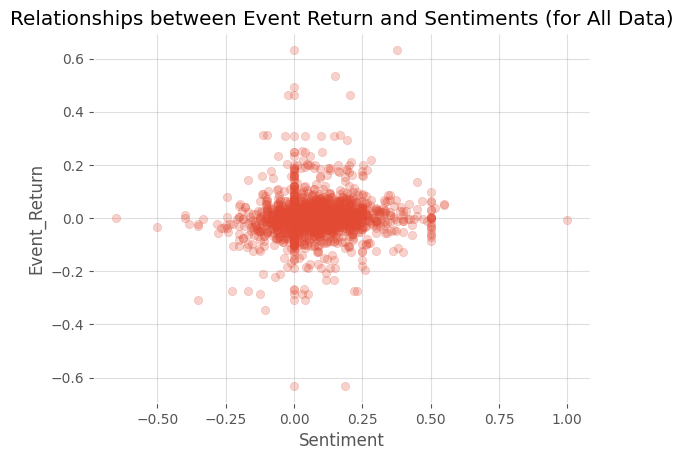

In [34]:
plt.scatter(Data_DF["sent_textblob"], 
            Data_DF["Event_Return"],
            alpha = 0.25)

plt.title("Relationships between Event Return and Sentiments (for All Data)")

plt.xlabel("Sentiment")
plt.ylabel("Event_Return")

plt.show()

In [35]:
corr = Data_DF["Event_Return"].corr(Data_DF["sent_textblob"]
                                   )
corr

0.07186281755161471

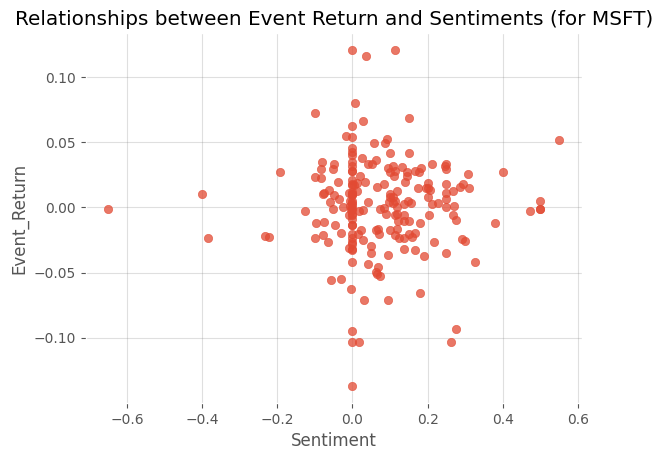

In [36]:
Data_DF_MSFT = Data_DF[Data_DF["ticker"] == "MSFT"]

plt.scatter(Data_DF_MSFT["sent_textblob"], Data_DF_MSFT["Event_Return"], alpha = 0.75)

plt.title("Relationships between Event Return and Sentiments (for MSFT)")

plt.xlabel("Sentiment")
plt.ylabel("Event_Return")

plt.show()

> Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centered around zero.

> We see that the statement has a positive sentiment of 0.5, but looking at the words that give rise to the sentiment score, we find that it is the word "touching" and not "high" that causes positive sentiment.

> In this step, we develop a customized model for sentiment analysis, based on available labeled data. The labeled data for this is obtained from the kaggle website. Let’s look at the data.

> The data has headlines for the news across 30 different stocks, with a total of 9470 rows, and has sentiments labeled 0 and 1. The headlines are already almost cleaned. We perform the classification steps that we learned in the previous weeks.

In [37]:
text_sample_2 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."

In [38]:
TextBlob(text_sample_2).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. 

### Supervised Machine Learning

> In order to run a supervised learning model, we first need to convert the news headlines into feature representation.

In [39]:
Sentiments_Data = pd.read_csv("labelled_news.csv",
                              encoding = "ISO-8859-1")

Sentiments_Data

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0
...,...,...,...,...
9465,4/11/2019 1:24,$WMT - Walmart shifts to remodeling vs. new st...,WMT,1
9466,4/10/2019 6:05,Walmart INC $WMT Holder Texas Permanent School...,WMT,0
9467,4/9/2019 4:38,$WMT $GILD:3 Dividend Stocks Perfect for Retir...,WMT,1
9468,4/9/2019 4:30,Walmart expanding use of #robots to scan shelv...,WMT,1


> Now that we have prepared the independent variable, we will train the classification model in a similar manner to the technique learned in the previous lessons. 

> We will first divide the data into a training set and a test set and then run the key classification models.

> Let's run all the classification models.

#### Word-embedding

In [40]:
all_vectors = np.array([np.array([token.vector for token in nlp(s)]
                                      ).mean(axis = 0) * np.ones((96)
                                                                   ) for s in Sentiments_Data["headline"]
                          ]
                         )

In [41]:
Y = Sentiments_Data["sentiment"]
X = all_vectors

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

In [43]:
val_size = 0.25

seed = 7

num_folds = 10

scoring = "accuracy"

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y,
                                                    test_size = val_size,
                                                    random_state = seed)

In [44]:
MODELS = []

In [45]:
MODELS.append(("LR", LogisticRegression()
              )
             )

MODELS.append(("KNN", KNeighborsClassifier()
              )
             )

MODELS.append(("SVM", SVC()
              )
             )

MODELS.append(("CART", DecisionTreeClassifier()
              )
             )

MODELS.append(("NN", MLPClassifier()
              )
             )

MODELS.append(("RF", RandomForestClassifier()
              )
             )

In [46]:
results = []

algorithms = []

kfold_results = []

train_results = []

test_results = []

for algo, MODEL in MODELS:
    
    kfold = KFold(n_splits = num_folds,
                  shuffle = True,
                  random_state = seed)
    
    cv_results = cross_val_score(MODEL,
                                 X_Train,
                                 Y_Train,
                                 cv = kfold,
                                 scoring = scoring)
    
    results.append(cv_results)
    
    algorithms.append(algo)
    
    res = MODEL.fit(X_Train, Y_Train)
    
    train_result = accuracy_score(res.predict(X_Train), Y_Train)
    
    train_results.append(train_result)
    
    test_result = accuracy_score(res.predict(X_Test), Y_Test)
    
    test_results.append(test_result)

    Message = "%s: %f (%f) %f %f" % (algo, cv_results.mean(), cv_results.std(), train_result, test_result)
    
    print(Message)
    
    print(confusion_matrix(res.predict(X_Test), Y_Test)
         )

LR: 0.737676 (0.014005) 0.749789 0.720017
[[ 617  248]
 [ 415 1088]]
KNN: 0.743586 (0.019953) 0.842439 0.758024
[[ 722  263]
 [ 310 1073]]
SVM: 0.783296 (0.018442) 0.823993 0.767314
[[ 653  172]
 [ 379 1164]]
CART: 0.641930 (0.016750) 0.999859 0.627534
[[605 455]
 [427 881]]
NN: 0.810613 (0.015459) 0.986201 0.794341
[[ 763  218]
 [ 269 1118]]
RF: 0.752739 (0.016059) 0.999859 0.736486
[[ 565  157]
 [ 467 1179]]


### Let's compare the Performance of Algorithms

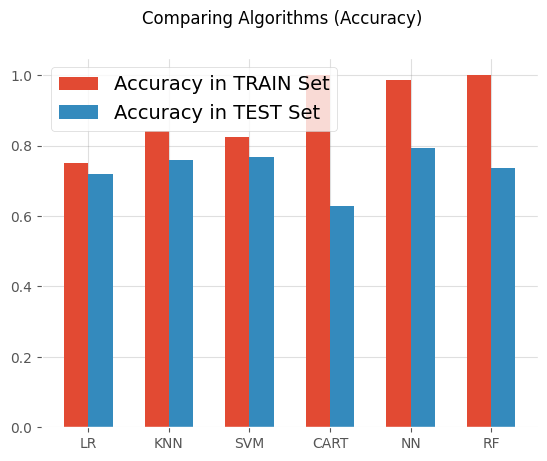

In [47]:
fig = plt.figure()

ind = np.arange(len(algorithms)
               )

width = 0.30

fig.suptitle("Comparing Algorithms (Accuracy)")

ax = fig.add_subplot(111)

plt.bar(ind - width/2, train_results, 
        width = width,
        label = "Accuracy in TRAIN Set")

plt.bar(ind + width/2, test_results, 
        width = width,
        label = "Accuracy in TEST Set")

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(algorithms)

plt.show()

### LSTM based model

***If I could see you in one more class, we will go for this :)***

### Unsupervised Machine Learning with Fiancial Lexicon

> Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.
VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package. 

In [48]:
SIA = SentimentIntensityAnalyzer()

In [49]:
stock_lexicon = pd.read_csv("lexicon.csv")

stock_lexicon

,Item,POS,Aff_Score,Neg_Score
0,'em,PR,0.380,0.533
1,'n,CC,1.413,1.200
2,'n handle,NaN,2.839,2.941
3,'s a,NaN,-0.023,-0.014
4,'s abc,NaN,2.262,2.300
...,...,...,...,...
20545,zoom,VB,-0.652,-0.649
20546,zortrades.com,NN,2.141,2.163
20547,zte,NN,4.934,5.084
20548,zuck,NN,-0.238,-0.185


In [50]:
stock_lexicon["sentiment"] = (stock_lexicon["Aff_Score"] + stock_lexicon["Neg_Score"]
                             )/2

In [51]:
stock_lexicon = dict(zip(stock_lexicon.Item, 
                         stock_lexicon.sentiment)
                    )

stock_lexicon = {k:v for k, v in stock_lexicon.items() if len(k.split(" "))==1}

stock_lexicon_scaled = {}

for k, v in stock_lexicon.items():
    if v > 0:
        stock_lexicon_scaled[k] = v / max(stock_lexicon.values()
                                         ) * 4
        
    else:
        stock_lexicon_scaled[k] = v / min(stock_lexicon.values()
                                         ) * -4
        
final_lexicon = {}
final_lexicon.update(stock_lexicon_scaled)
final_lexicon.update(SIA.lexicon)
SIA.lexicon = final_lexicon

In [52]:
text_sample_3 = "AAPL has little competition from any of the tech companies"

In [53]:
text_sample_3 = "AAPL is trading higher after reporting its October sales rose 11.2% M/M. It has seen a 25% jump in orders"

In [54]:
SIA.polarity_scores(text_sample_3)["compound"]

0.4535

In [55]:
TextBlob(text_sample_3).sentiment_assessments

Sentiment(polarity=0.425, subjectivity=0.725, assessments=[(['higher'], 0.25, 0.5, None), (['rose'], 0.6, 0.95, None)])

In [56]:
vader_sentiments = np.array([SIA.polarity_scores(s)["compound"] for s in Data_DF["headlines"]
                               ]
                              )
vader_sentiments.shape

(1724,)

In [57]:
Data_DF

,ticker,headlines,date,Event_Return,Close,sent_textblob
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.018,10.059,0.262
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013,33.884,-0.044
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.020,19.956,0.167
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.020,19.956,-0.031
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.007,10.304,0.000
...,...,...,...,...,...,...
1728,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013,67.198,0.093
1729,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.006,35.187,-0.010
1730,TSLA,Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...,2018-12-26,-0.003,21.739,0.200
1731,TSLA,Tesla's (TSLA +1.2%) move to add Oracle co-fou...,2018-12-28,-0.631,22.258,0.188


In [58]:
Data_DF["sent_lex"] = vader_sentiments

In [59]:
corr = Data_DF["Event_Return"].corr(Data_DF["sent_lex"]
                                   )
corr

0.15991084543976272

Text(0.5, 0, 'Sentiments')

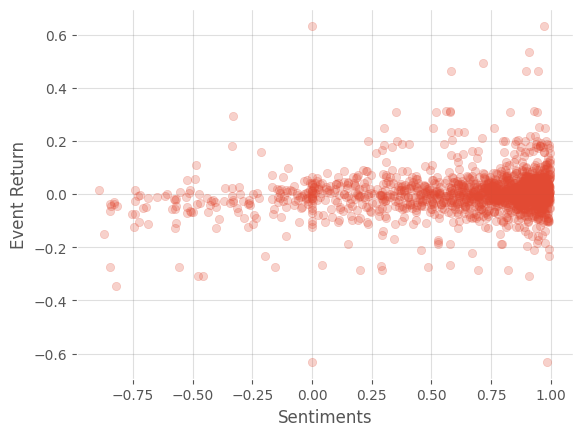

In [60]:
plt.scatter(Data_DF["sent_lex"], Data_DF["Event_Return"],
           alpha = 0.25)

plt.ylabel("Event Return")
plt.xlabel("Sentiments")

Text(0.5, 0, 'Sentiments')

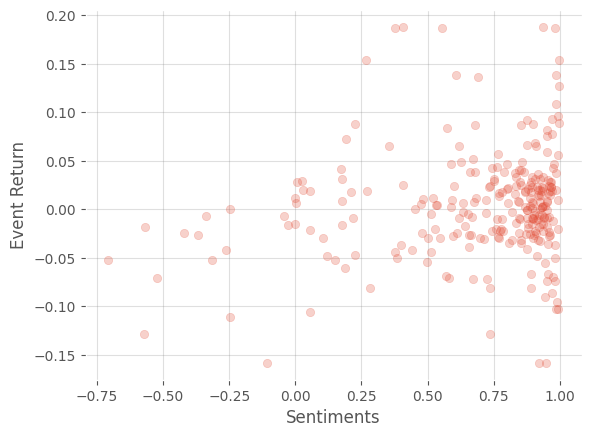

In [61]:
Data_DF_Amazon = Data_DF[Data_DF["ticker"] == "AMZN"]
plt.scatter(Data_DF_Amazon["sent_lex"], Data_DF_Amazon["Event_Return"],
           alpha = 0.25)

plt.ylabel("Event Return")
plt.xlabel("Sentiments")

### EDA and Comparisons

> Let us look at the sample headlines and the sentiments from three different methodologies, followed by an analysis that makes use of visualization.

In [62]:
New_Data_DF = Data_DF[Data_DF["ticker"] == "NFLX"][["ticker", "headlines", "sent_textblob", "sent_lex"]]

from pandas import option_context

with option_context("display.max_colwidth", 400):
    display(New_Data_DF)

,ticker,headlines,sent_textblob,sent_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.044,0.858
17,NFLX,"Today's strength in Netflix (NFLX +4.8%) is attributed to comments from Mark Zuckerberg that Facebook has been in discussions with NFLX related to potential integration of social networking tools. Music, TV shows and books will be among the next products to go social through the website, Zuckerberg says.",0.013,0.653
34,NFLX,"Netflix (NFLX +3.4%) CEO Reed Hastings jumps on Facebook's board - interesting in light of the idea the companies may be getting more likely to cooperate than compete (previously: I, II, III).",0.247,0.739
39,NFLX,"A few reasons why Netflix (NFLX +7.9%) could profit from Latin America: over 600M people, growing economies, increasing broadband usage, and a strategy that involves combining Hollywood studio libraries with local content. However, addressing the ""local nuances attached to reaching customers in each individual market"" won't be easy.",0.047,0.813
41,NFLX,"Dawson James boldly initiates coverage of Netflix (NASDAQ:NFLX) at Sell with a $181 downside target, citing an 8.7% Y/Y drop in per-subscriber revenue, increased competition (Hulu, AMZN, Facebook, GOOG), rising content costs, and consolidation among CDNs. For now, NFLX is +5% to $281.44. (earlier)",0.167,0.883
...,...,...,...,...
1655,NFLX,"Netflix (NASDAQ:NFLX) is down 3.9% amid a down day in the tech sector. The streamer is underperforming following an update from Morgan Stanley on Apple's potential content launch. ""We forecast that an Apple Video streaming service with high quality but limited breadth could be priced at the low end vs. competitors, or $7.99/month, and reach over 50M paid subscribers by 2025, compared to 124M a...",-0.062,0.857
1665,NFLX,Netflix (NASDAQ:NFLX) is set to land on Sky's (OTCPK:SKYAY),0.000,0.110
1676,NFLX,"Credit Suisse previews how the 2019 content slate is looking for Netflix (NASDAQ:NFLX). The firm says 2019 content is shaping up to be ""meaningfully stronger"" than 2018 in a development that bodes well for subscriber growth, both domestic and globally. CS notes that promising movies include Martin Scorsese's The Irishman and Michael Bay's Six Underground. New series include The Witcher and the...",0.135,0.980
1721,NFLX,Bernstein analyst,0.000,0.260


In [63]:
text = 'LinkedIn (LNKD) could have an exceptional drop in its price over the coming months'

In [64]:
data = [["LNKD", "LinkedIn (LNKD) could have an exceptional drop in its price over the coming months", -.1945, 0.66]]

DF = pd.DataFrame(data, columns = ["ticker", "News", "sentiment_financial", "sentiment_mov"])

with option_context("display.max_colwidth", 200):
    display(DF)

,ticker,News,sentiment_financial,sentiment_mov
0,LNKD,LinkedIn (LNKD) could have an exceptional drop in its price over the coming months,-0.195,0.660


In [65]:
SIA.polarity_scores(text)["compound"]

-0.1945

In [66]:
TextBlob(text).sentiment.polarity

0.6666666666666666

In [67]:
TextBlob(text).sentiment_assessments.assessments

[(['exceptional'], 0.6666666666666666, 1.0, None)]

<Axes: title={'center': 'Correlation Matrix'}>

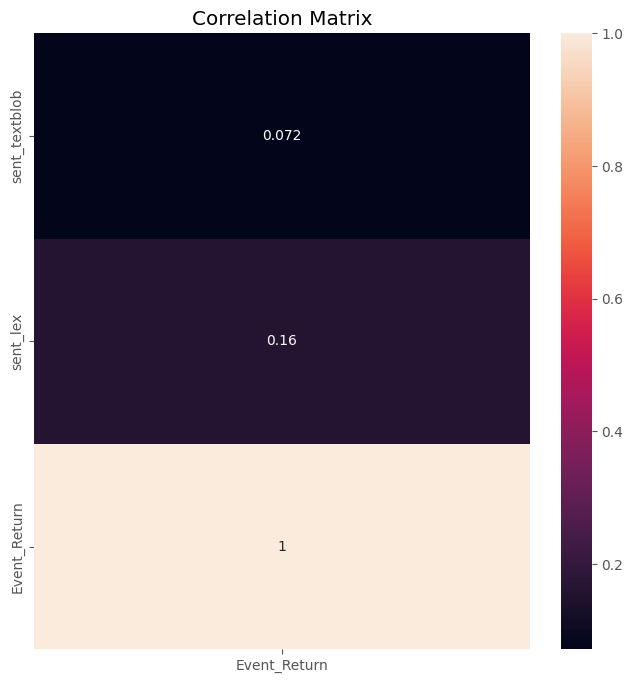

In [68]:
corr = Data_DF[["sent_textblob", "sent_lex", "Event_Return"]].dropna(axis =0).corr()

plt.figure(figsize = (8, 8)
          )
plt.title("Correlation Matrix")
sns.heatmap(corr[["Event_Return"]],
            annot = True)

In [69]:
corr_data = []

for ticker in Data_DF["ticker"].unique():

    New_Data_DF = Data_DF[Data_DF["ticker"] == ticker]
    
    if New_Data_DF.shape[0] > 40 :
        corr_textblob = New_Data_DF["Event_Return"].corr(New_Data_DF["sent_textblob"])
        corr_lex = New_Data_DF["Event_Return"].corr(New_Data_DF["sent_lex"])
        corr_data.append([ticker, corr_textblob, corr_lex])
    else:
        continue

In [70]:
corr_DF = pd.DataFrame(corr_data,
                       columns = ["ticker", "corr_textblob", "corr_lex"]
                       )
corr_DF = corr_DF.set_index("ticker")
corr_DF

,corr_textblob,corr_lex
ticker,,
AMZN,0.039,0.172
NFLX,0.106,0.241
MSFT,0.010,0.132
GOOG,0.046,0.150
JPM,0.041,-0.024
TSLA,0.079,0.143
AAPL,0.154,0.168
WMT,0.264,0.140
ADBE,0.119,0.224


<a id="test"></a>

### [Predictive Model Assessment, Strategy Building, and Backtesting](#test)

> Sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with a positive score and selling the stocks with a negative score. 

> The sentiments can also be used as additional features over and above other features (such as correlated stocks and technical indicators) in a supervised learning model to predict the price or come up with a trading strategy.

> In the trading strategy in the current problem solving task, we buy and sell stock as per the current stock sentiments: 

* Buy a stock when the change in sentiment score (current sentiment score - previous sentiment score) is greater than 0.5 and sell a stock when the change in sentiment score is less than -0.5.
<br>

* In addition, we check the 15-day moving average when buying or selling in a unit of 100.

> Surely, there can be many ways to create a trading strategy based on sentiments, by varying the threshold or changing the number of units based on the initial cash available.

> We will use lexicon-based sentiments for the trading strategy.

### Our Strategy

In [71]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

> Here we will use Backtrader, a Python-based API for writing and backtesting trading strategy.  

> Backtrader allows you to focus on writing reusable trading strategies, indicators, and analyzers instead of having to spend time building infrastructure. We have a convenient framework to backtest and write our trading strategy. 

> We will implement a simple strategy to buy if the previous day’s sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5.

The following function contains two classes:

* Sentiment

* SentimentStrat: The "next" function of this class implements the actual trading strategy.


In [72]:
class Sentiment(bt.Indicator):
    lines = ("sentiment",)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]
                          ).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment

class SentimentStrat(bt.Strategy):
    params = (
        ("period", 15),
        ("printlog", True),
    )

    def log(self, txt, dt=None, doprint=False):
        """ 
        Logging function for this strategy
        """
        
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print("%s, %s" % (dt.isoformat(), txt)
                 )

    def __init__(self):
        
        # Keep a reference to the "close" line in the data[0] dataseries
        
        self.dataclose = self.datas[0].close
        
        # Keep track of pending orders
        
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            
            return
        
        # Check if an order has been completed
        
        ###### ATTENTION: broker could reject order if not enough cash #######
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    "BUY DONE, Price: %.2f, Cost: %.2f, Comm %.2f" %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log("SELL DONE, Price: %.2f, Cost: %.2f, Comm %.2f" %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")
            
        # Write down: no pending order
        
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log("Profit of the operation, GROSS %.2f, NET %.2f" %
                 (trade.pnl, trade.pnlcomm))
    
    #### Main Strategy ####
    
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        
        if self.order:
            return       
        
        # If not in the market and previous sentiment not none
        
        if not self.position and prev_sentiment:
            
            # buy if current close more than sma AND sentiment increased by >= 0.5
            
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                
                self.log("Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f" % (prev_sentiment, self.sentiment, self.dataclose[0]
                                                                                          )
                        )    
                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        
        elif prev_sentiment:
        
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log("Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f" % (prev_sentiment, self.sentiment, self.dataclose[0]
                                                                                           )
                        )            
                
                self.order = self.sell()

    def stop(self):
        self.log("(MA Period %2d) Ending Value %.2f" %
                 (self.params.period, self.broker.getvalue()), doprint=True)
        
        

### Function for running the trading strategy

> Now, let’s build a generic to run the strategy for any stock. 

> We will specify the “ticker” stock feeds to be pulled from Yahoo Finance, and set an initial amount of $100,000, with a fixed size of 100 lots per trade.

In [73]:
def run_our_strategy(ticker, start, end):
    print(ticker)
    
    ticker = yf.Ticker(ticker)
    
    df_ticker = ticker.history(start = start,
                               end = end)
    
    BRAIN = bt.Cerebro()
    
    BRAIN.addstrategy(SentimentStrat)
    
    data = bt.feeds.PandasData(dataname = df_ticker)
    
    BRAIN.adddata(data)
    
    start = 100000.0
    
    BRAIN.broker.setcash(start)
    
    BRAIN.addsizer(bt.sizers.FixedSize, stake = 100)
    
    print("Starting Value of Our Portfolio: %.2f" % start)
    
    plt.rcParams["font.size"] = "14"
    
    plt.rcParams["figure.figsize"] = [14, 10]
    
    BRAIN.run()
    
    BRAIN.plot(volume = False,
               iplot = True,
               plotname = ticker)
    
    end = BRAIN.broker.getvalue()
    
    print("Starting Value of Our Portfolio: %.2f\nFinal Value of Our Portfolio: %.2f\nProfit: %.2f\n" % (start, end, end - start)
         )
    
    return float(df_ticker["Close"][0]), (end - start)

### Individual Stocks

In [74]:
ticker = "GOOG"

date_sentiment = Data_DF[Data_DF["ticker"].isin([ticker]
                                               )
                        ]

date_sentiment = date_sentiment[["date", "sent_lex"]]

date_sentiment["date"] = pd.to_datetime(date_sentiment["date"], 
                                        format = "%Y-%m-%d").dt.date

date_sentiment = date_sentiment.set_index("date")["sent_lex"]

date_sentiment = date_sentiment.to_dict()

run_our_strategy(ticker, 
                 start = "2012-01-01",
                 end = "2018-12-12")

GOOG
Starting Value of Our Portfolio: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.21
2012-04-13, BUY DONE, Price: 16.13, Cost: 1612.83, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.31
2012-10-19, SELL DONE, Price: 17.57, Cost: 1612.83, Comm 0.00
2012-10-19, Profit of the operation, GROSS 144.53, NET 144.53
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.47
2013-01-11, BUY DONE, Price: 18.48, Cost: 1848.07, Comm 0.00
2014-07-17, Previous Sentiment 0.92, New Sentiment 0.09 SELL CREATE, 28.61
2014-07-18, SELL DONE, Price: 29.57, Cost: 1848.07, Comm 0.00
2014-07-18, Profit of the operation, GROSS 1108.81, NET 1108.81
2014-07-18, Previous Sentiment 0.09, New Sentiment 0.99 BUY CREATE, 29.67
2014-07-21, BUY DONE, Price: 29.51, Cost: 2950.65, Comm 0.00
2014-09-12, Previous Sentiment 0.94, New Sentiment 0.22 SELL CREATE, 28.70
2014-09-15, SELL DONE, Price: 28.57, Cost: 2950.65, Comm 0.00
2014-09-15

<IPython.core.display.Javascript object>

Starting Value of Our Portfolio: 100000.00
Final Value of Our Portfolio: 101560.75
Profit: 1560.75



(16.573129653930664, 1560.749626159668)

In [75]:
Data_DF_GOOG = Data_DF[Data_DF["ticker"].isin([ticker])]

previous_news = list(Data_DF_GOOG[Data_DF_GOOG["date"] == "2017-04-27"]["headlines"])
 
present_news = list(Data_DF_GOOG[Data_DF_GOOG["date"] == "2017-04-28"]["headlines"])

print("Previous News:", previous_news,"\n\n\n", "Present News:", present_news)

Previous News: ["Alphabet shares are up after hours (GOOG +4.4%, GOOGL +3%) after beating on top and bottom lines in its Q1 earnings on the back of heavy sales gains.    Revenues rose 22%, and 24% in constant currency. Meanwhile, operating income rose 23% to $6.57B with a 27% margin, up from a year-ago 26%.    Traffic acquisition costs to Google Network members rose 9.8% to $2.82B; that's 70% of Network Members properties' revenues. TAC to distribution partners jumped 48% to $1.8B (10% of Google properties' revenues). Total TAC of $4.6B made up 22% of Google ad revenues.    Revenue by segment: Ad revenues, $21.4B (up 18.8%; Google properties, $17.4B, Network Members properties, $4B); Other Google, $3.1B (up 49.4%); Other Bets, $244M (up 47.9%).    Cash and equivalents and marketable securities came to $92.4B at quarter's end. Free cash flow was $7B on net cash from operations of $9.55B.    Conference call to come at 4:30 p.m. ET.   Press Release", 'Alphabet (NASDAQ:GOOG): Q1 EPS of $7.

> First running the strategy for Google.

> The chart will divided into three panels.

* Top Panel: The top panel is the Cash Value Observer, which, as the name implies, keeps track of the cash and total portfolio value during the life of the backtesting run. As we can see in this panel, we started with $100,000.00 and the final value at the end is __________ .
<br>

* Second Panel: This panel is Trade Observer, which shows, at the end of a trade, the actual profit and loss. A trade is defined as opening a position and taking the position back to zero (directly or crossing over from long to short or short to long).
<br>

* Third Panel: This panel is Buy Sell Observer, which plots (in addition to the prices) where buy and sell operations have taken place. 
<br>

* Bottom Panel : This panel shows the sentiment score.

In [76]:
ticker = "AMZN"

date_sentiment = Data_DF[Data_DF["ticker"].isin([ticker]
                                               )
                        ]

date_sentiment = date_sentiment[["date", "sent_lex"]]

date_sentiment["date"] = pd.to_datetime(date_sentiment["date"], 
                                        format = "%Y-%m-%d").dt.date

date_sentiment = date_sentiment.set_index("date")["sent_lex"]

date_sentiment = date_sentiment.to_dict()

run_our_strategy(ticker, 
                 start = "2012-01-01",
                 end = "2018-12-12")

AMZN
Starting Value of Our Portfolio: 100000.00
2013-01-30, Previous Sentiment 0.40, New Sentiment 0.95 BUY CREATE, 13.64
2013-01-31, BUY DONE, Price: 13.55, Cost: 1355.20, Comm 0.00
2013-04-18, Previous Sentiment 0.89, New Sentiment 0.38 SELL CREATE, 12.97
2013-04-19, SELL DONE, Price: 12.91, Cost: 1355.20, Comm 0.00
2013-04-19, Profit of the operation, GROSS -64.40, NET -64.40
2013-11-13, Previous Sentiment 0.44, New Sentiment 0.99 BUY CREATE, 17.81
2013-11-14, BUY DONE, Price: 17.87, Cost: 1786.95, Comm 0.00
2014-01-06, Previous Sentiment 0.89, New Sentiment -0.25 SELL CREATE, 19.68
2014-01-07, SELL DONE, Price: 19.75, Cost: 1786.95, Comm 0.00
2014-01-07, Profit of the operation, GROSS 188.25, NET 188.25
2014-01-30, Previous Sentiment -0.25, New Sentiment 0.97 BUY CREATE, 20.15
2014-01-31, BUY DONE, Price: 18.59, Cost: 1858.80, Comm 0.00
2014-07-08, Previous Sentiment 0.95, New Sentiment 0.05 SELL CREATE, 16.19
2014-07-09, SELL DONE, Price: 16.24, Cost: 1858.80, Comm 0.00
2014-07-09

(8.951499938964844, 4970.00036239624)

### Multiple Stocks

In [77]:
results_tickers = {}

for ticker in tickers:

    date_sentiment = Data_DF[Data_DF["ticker"].isin([ticker]
                                               )
                        ]

    date_sentiment = date_sentiment[["date", "sent_lex"]]


    date_sentiment["date"] = pd.to_datetime(date_sentiment["date"], 
                                        format = "%Y-%m-%d").dt.date


    date_sentiment = date_sentiment.set_index("date")["sent_lex"]


    date_sentiment = date_sentiment.to_dict()

    results_tickers[ticker] = run_our_strategy(ticker, 
                                               start = "2012-01-01",
                                               end = "2018-12-12")

AAPL
Starting Value of Our Portfolio: 100000.00
2012-02-06, Previous Sentiment -0.17, New Sentiment 0.38 BUY CREATE, 14.03
2012-02-07, BUY DONE, Price: 14.07, Cost: 1406.72, Comm 0.00
2012-04-13, Previous Sentiment 0.69, New Sentiment -0.74 SELL CREATE, 18.30
2012-04-16, SELL DONE, Price: 18.45, Cost: 1406.72, Comm 0.00
2012-04-16, Profit of the operation, GROSS 437.84, NET 437.84
2014-04-24, Previous Sentiment 0.43, New Sentiment 0.99 BUY CREATE, 17.86
2014-04-25, BUY DONE, Price: 17.76, Cost: 1775.88, Comm 0.00
2015-08-21, Previous Sentiment 1.00, New Sentiment -0.06 SELL CREATE, 23.94
2015-08-24, SELL DONE, Price: 21.47, Cost: 1775.88, Comm 0.00
2015-08-24, Profit of the operation, GROSS 371.40, NET 371.40
2016-07-27, Previous Sentiment 0.42, New Sentiment 0.99 BUY CREATE, 23.67
2016-07-28, BUY DONE, Price: 23.64, Cost: 2364.40, Comm 0.00
2017-08-01, Previous Sentiment 0.91, New Sentiment 0.23 SELL CREATE, 35.16
2017-08-02, SELL DONE, Price: 37.33, Cost: 2364.40, Comm 0.00
2017-08-0

Starting Value of Our Portfolio: 100000.00
Final Value of Our Portfolio: 105815.00
Profit: 5815.00



In [78]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["Per Unit Start Price",
                                                             "Strategy Profit"]
                                                           )
                                                  ]
                                                 )

,AAPL,MSFT,AMZN,GOOG,META,WMT,JPM,TSLA,NFLX,ADBE
Per Unit Start Price,12.434,21.239,8.951,16.573,38.189,15.482,24.839,1.872,10.320,28.570
Strategy Profit,2438.616,6677.408,4970.000,1560.750,0.000,-242.826,701.519,276.200,16546.571,5815.000


### Varying the strategy time period

In [79]:
results_tickers = {}

for ticker in tickers:

    date_sentiment = Data_DF[Data_DF["ticker"].isin([ticker]
                                               )
                        ]

    date_sentiment = date_sentiment[["date", "sent_lex"]]


    date_sentiment["date"] = pd.to_datetime(date_sentiment["date"], 
                                        format = "%Y-%m-%d").dt.date


    date_sentiment = date_sentiment.set_index("date")["sent_lex"]


    date_sentiment = date_sentiment.to_dict()

    results_tickers[ticker] = run_our_strategy(ticker, 
                                               start = "2012-01-01",
                                               end = "2015-05-04")

AAPL
Starting Value of Our Portfolio: 100000.00
2012-02-06, Previous Sentiment -0.17, New Sentiment 0.38 BUY CREATE, 14.03
2012-02-07, BUY DONE, Price: 14.07, Cost: 1406.72, Comm 0.00
2012-04-13, Previous Sentiment 0.69, New Sentiment -0.74 SELL CREATE, 18.30
2012-04-16, SELL DONE, Price: 18.45, Cost: 1406.72, Comm 0.00
2012-04-16, Profit of the operation, GROSS 437.84, NET 437.84
2014-04-24, Previous Sentiment 0.43, New Sentiment 0.99 BUY CREATE, 17.86
2014-04-25, BUY DONE, Price: 17.76, Cost: 1775.88, Comm 0.00
2015-05-01, (MA Period 15) Ending Value 101555.37
Starting Value of Our Portfolio: 100000.00
Final Value of Our Portfolio: 101555.37
Profit: 1555.37

MSFT
Starting Value of Our Portfolio: 100000.00
2012-03-08, Previous Sentiment -0.11, New Sentiment 0.92 BUY CREATE, 25.56
2012-03-09, BUY DONE, Price: 25.64, Cost: 2563.51, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 24.92
2012-04-05, SELL DONE, Price: 24.88, Cost: 2563.51, Comm 0.00
2012-04-0

In [80]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["Per Unit Start Price",
                                                             "Strategy Profit"]
                                                           )
                                                  ]
                                                 )

,AAPL,MSFT,AMZN,GOOG,META,WMT,JPM,TSLA,NFLX,ADBE
Per Unit Start Price,12.434,21.239,8.951,16.573,38.189,15.482,24.839,1.872,10.320,28.570
Strategy Profit,1555.371,871.834,127.450,1159.550,0.000,-242.826,1488.091,891.867,5969.143,4207.000


### What We've Learned and What's Next 

> We found a good performance of the sentiment-based strategy across all the stocks except _______. 

> Our sentiment-based strategy performs quite well in different time periods. The strategy can be further tweaked to modify the threshold and order size. 

> Additional metrics such as the Sharpe ratio and maximum drawdown can also be used to understand the performance of the strategy. This will be examined in Exercise Problem Set #5. Sentiments can also be used along with other features, such as correlated variables and technical indicators, for prediction.

> We performed a comparison of the models and concluded that one of the most important steps in training the model for sentiment analysis is training it using domain-specific vocabulary.

> We further used the sentiments as signals to develop different trading strategies. This initial result suggests that a model trained on financial lexicon-based sentiments could prove viable as a trading strategy.

> Additional improvements to the entire processes of NLP-based strategy building can be made by using more complex pre-trained sentiment analysis models, such as Bert by Google or different pre-trained NLP models available on open-source platforms. Existing NLP libraries fill in some of the pre-processing and encoding steps to allow us to focus on the inference step.

<!-- ![gift](https://images.squarespace-cdn.com/content/v1/53f3eb3ce4b077de0318f4ea/628aea48-e976-49e7-a779-f8355fb7e171/For_QF627.gif?format=2500w "gift") -->

> `Thank you for working with the script, Team 👍`